# LSTM RNN TRAINING TO CLASSIFY SPAM AND NOT SPAM SMS

# Import the necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


# Unzip the File/Dataset

In [0]:
from zipfile import ZipFile
file_name = "/content/sms-spam-collection-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Read the dataset

In [0]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Drop un-important columns

In [0]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [0]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Plot to see the ratio of Smap vs Not Spam

Text(0.5, 1.0, 'Number of ham and spam messages')

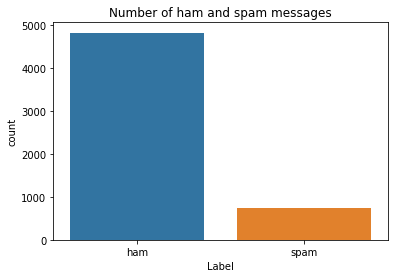

In [0]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

## TEST TRAIN SPLIT
### Label Encoding the Test

In [0]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [0]:
X.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [0]:
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

### Splitting into test and train

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

## PROCESSING THE DATA


> 
    Tokenize the data and convert the text to sequences.

    Add padding to ensure that all the sequences have the same shape.

    There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.




In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

# Defining the MODEL

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

## Compiling and Seeing the Model

In [0]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

## Training Accuracy

Fit on the training Data

In [0]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 9s 2ms/step - loss: 0.3332 - acc: 0.8664 - val_loss: 0.1403 - val_acc: 0.9515
Epoch 2/10
3788/3788 [==============================] - 8s 2ms/step - loss: 0.0877 - acc: 0.9760 - val_loss: 0.0389 - val_acc: 0.9884
Epoch 3/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0471 - acc: 0.9844 - val_loss: 0.0310 - val_acc: 0.9905
Epoch 4/10
3788/3788 [==============================] - 8s 2ms/step - loss: 0.0362 - acc: 0.9889 - val_loss: 0.0306 - val_acc: 0.9926
Epoch 5/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0285 - acc: 0.9916 - val_loss: 0.0261 - val_acc: 0.9916
Epoch 6/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0230 - acc: 0.9939 - val_loss: 0.0252 - val_acc: 0.9926
Epoch 7/10
3788/3788 [==============================] - 8s 2ms/step - loss: 0.0179 - acc: 0.9950 - val_loss: 0.0354 - val_acc: 0.9884


## Processing the Test Data

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

### **Evaluating on the Test Data**

In [0]:
accr = model.evaluate(test_sequences_matrix,Y_test)

836/836 [==============================] - 0s 529us/step


## Getting the Test Accuracy

In [0]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.052
  Accuracy: 0.981


***The Accuracy comes out to be  very near the train accuracy, the model is well trained.***